# Zebrafish Spatially differential expression analysis

This notebook shows downstream analysis pipeline for zebrafish spatial expression data.

This notebook assumes the following files are available:
```
res_mt.csv
res_wt.csv
zf_geometry.txt
geometry_sample.tsv
```

Where `res_mt.csv` and `res_wt.csv` are matrices of expression values (rows = spatial points, columns = genes),
`zf_geometry.txt` contains 3D surface points, and `geometry_sample.tsv` contains metadata for each spatial location (including a `tier` field).


## 1) Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from scipy import stats
from statsmodels.stats.multitest import multipletests

import zfish_vis as zv # from spaOTsc paper (Cang et al. Nature communication, 2020)

random.seed(0)
np.random.seed(0)

## 2) Load Data

In [ ]:
# Load ZENomix's results (rows = positions, columns = genes)
res_mt = pd.read_csv('YourPath/res_mt.csv', index_col=0)
res_wt = pd.read_csv('YourPath/res_wt.csv', index_col=0)

### Geometry for 3D visualization

In [ ]:
df_pts = pd.read_csv("YourPath/zf_geometry.txt", sep=' ')
info = pd.read_csv("YourPath/geometry_sample.tsv", sep='\t')
pts = np.array(df_pts.values, float)

### Set color scale bounds based on WT distribution

In [4]:
vmin = np.quantile(res_wt, 0.01)
vmax = np.quantile(res_wt, 0.99)
vmin, vmax

(np.float64(-0.02491577794808843), np.float64(5.565227210734412))

## 3) Difference Analysis (MT − WT)

In [5]:
df_diff = res_mt - res_wt
df_diff.index = info.index
counts_df = res_mt - res_wt  # alias, if needed later
df_max = np.quantile(df_diff, 0.99)
df_min = -df_max

# Per-gene summary stats
ma = abs(df_diff.max())
me = df_diff[(info['tier'] == '1-2') | (info['tier'] == '3-4')].mean()
mi = abs(df_diff.min())
sd = df_diff.std(ddof=0)

mm = pd.DataFrame(columns=df_diff.columns)
for g in df_diff.columns:
    mm[g] = [max(ma[g], mi[g]), me[g], sd[g]]
mm.index = ['max_diff', 'mean_diff', 'std']
mm = mm.T

# Selection by thresholds
subset = mm.copy()
subset = subset[subset['max_diff'] > 2]
subset = subset[subset['max_diff'] < 8]
subset = subset[subset['std'] > 0.72]

subset_2 = mm.copy()
subset_2 = subset_2.query('max_diff < 2 or max_diff > 8 or std < 0.72')

len_subset = len(subset)
len_subset

142

### Visualize selection boundaries

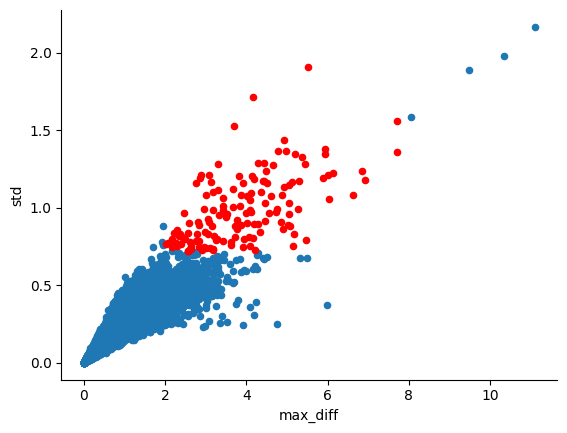

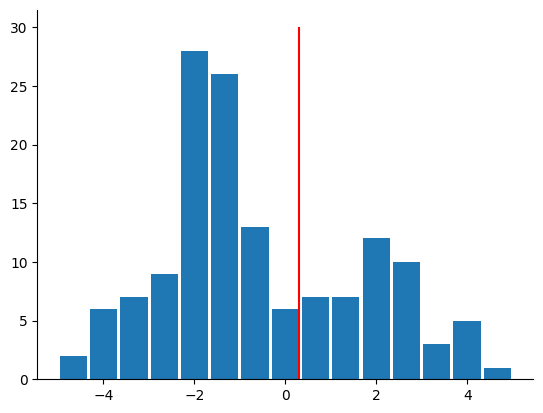

In [6]:
ax1 = subset_2.plot.scatter(x='max_diff', y='std')
subset.plot.scatter(x='max_diff', y='std', ax=ax1, c='red')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

subset['mean_diff'].hist(bins=15, rwidth=0.9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.vlines(x=0.3, ymin=0, ymax=30, color='red')
plt.grid(False)
plt.show()

### Split into up- vs. down-trending groups

In [7]:
usubset = subset[subset['mean_diff'] > 0.3]
dsubset = subset[subset['mean_diff'] < 0.3]
DEGs = usubset.index
len(DEGs)

45

## 4) Cluster Upregulated Genes

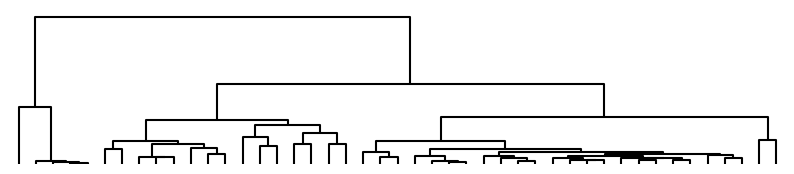

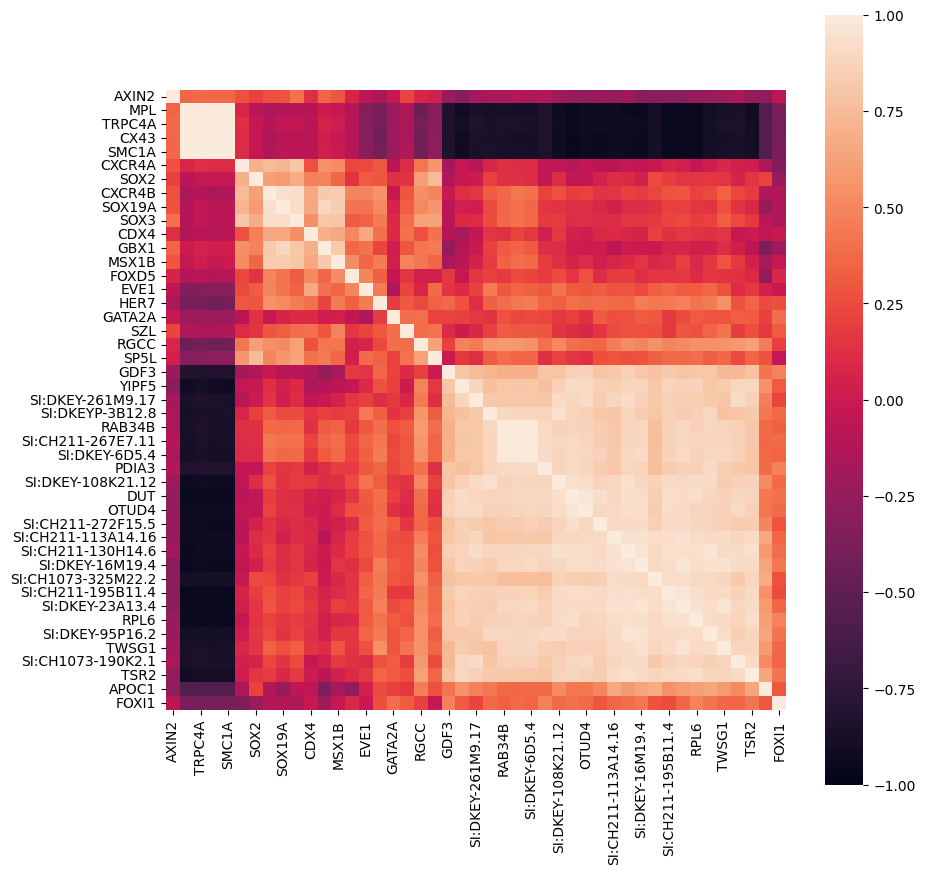

1
Index(['AXIN2', 'CX43', 'MPL', 'SMC1A', 'TRPC4A'], dtype='object')
2
Index(['CDX4', 'CXCR4A', 'CXCR4B', 'EVE1', 'FOXD5', 'GATA2A', 'GBX1', 'HER7',
       'MSX1B', 'RGCC', 'SOX19A', 'SOX2', 'SOX3', 'SP5L', 'SZL'],
      dtype='object')
3
Index(['APOC1', 'DUT', 'FOXI1', 'GDF3', 'OTUD4', 'PDIA3', 'RAB34B', 'RPL6',
       'SI:CH1073-190K2.1', 'SI:CH1073-325M22.2', 'SI:CH211-113A14.16',
       'SI:CH211-130H14.6', 'SI:CH211-195B11.4', 'SI:CH211-267E7.11',
       'SI:CH211-272F15.5', 'SI:DKEY-16M19.4', 'SI:DKEY-23A13.4',
       'SI:DKEY-6D5.4', 'SI:DKEY-95P16.2', 'TSR2', 'TWSG1', 'YIPF5',
       'SI:DKEY-108K21.12', 'SI:DKEY-261M9.17', 'SI:DKEYP-3B12.8'],
      dtype='object')


In [8]:
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearrange the correlation matrix so that groups of highly correlated
    variables are adjacent.
    Returns a re-ordered correlation matrix and the clustering linkage.
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    if not inplace:
        corr_array = corr_array.copy()
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :], idx_to_cluster_array, linkage
    return corr_array[idx, :][:, idx], idx_to_cluster_array

res, idx, linkage = cluster_corr(df_diff[DEGs].corr())

plt.figure(figsize=(10, 2))
plt.axis('off')
dendro = dendrogram(linkage, orientation='top', labels=DEGs,
                    distance_sort='ascending', link_color_func=lambda x: 'black')
plt.show()

res = df_diff[DEGs].corr().iloc[dendro['leaves']].iloc[:, dendro['leaves']]
plt.figure(figsize=(10, 10))
sns.heatmap(res, square=True, vmax=1., vmin=-1.)
plt.show()

# Print cluster membership
for i in range(1, max(idx) + 1):
    print(i)
    print(usubset.index[idx == i])

## 5) Representative Spatial Patterns

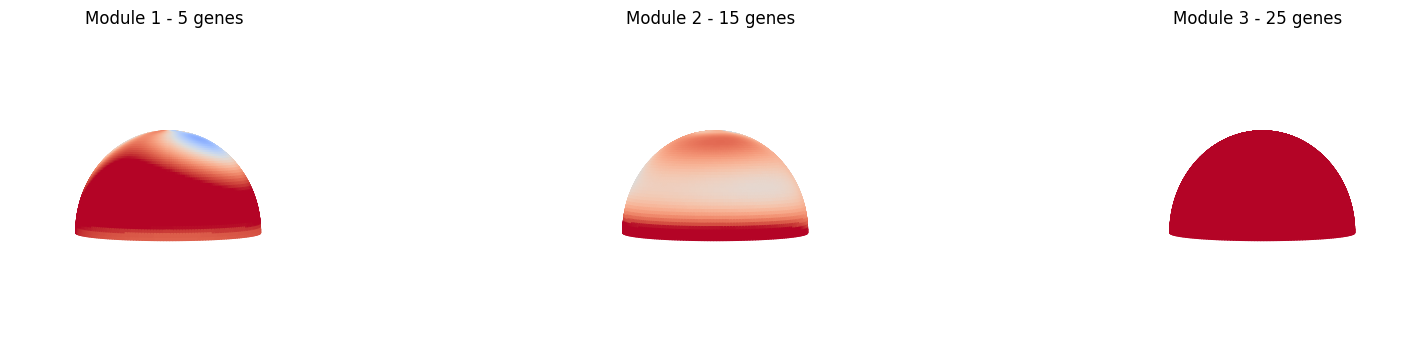

In [9]:
rep_pattern = pd.DataFrame(columns=[i for i in range(1, max(idx) + 1)])
for i in range(1, max(idx) + 1):
    rep_pattern[i] = np.mean(df_diff[usubset.index[idx == i]].values, axis=1)

C = len(rep_pattern.columns)
fig, ax = plt.subplots(1, C, figsize=(20, 4), subplot_kw=dict(projection='3d'))
for i in range(C):
    geo, cs = zv.get_grid_color_interpolate(pts, rep_pattern[i + 1], vmin=df_min, vmax=df_max)
    plt.subplot(1, C, i + 1)
    ax[i].plot_surface(geo[0], geo[1], geo[2], facecolors=plt.cm.coolwarm(cs), shade=False, rstride=1, cstride=1)
    ax[i].set_box_aspect((8, 8, 4))
    ax[i].axis('off')
    ax[i].view_init(elev=3, azim=180)
    ax[i].set_title(f'Module {i + 1} - {len(usubset.index[idx == i + 1])} genes')
plt.show()

## 6) Show the identified genes

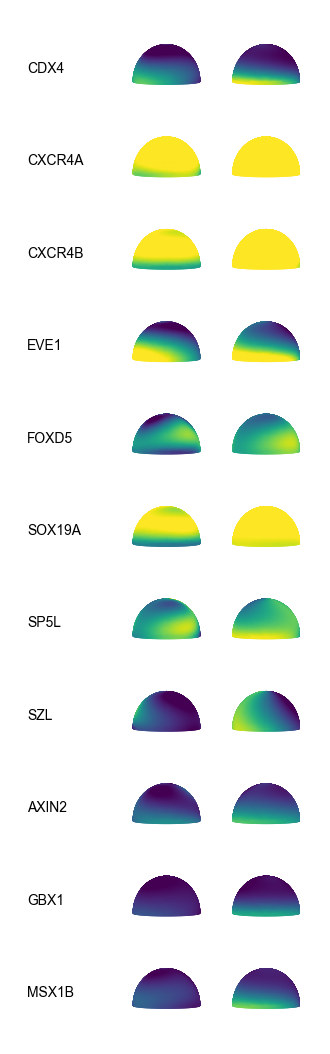

In [ ]:
identified_genes = [
    'CDX4','CXCR4A','CXCR4B','EVE1','FOXD5','SOX19A','SP5L','SZL','AXIN2','GBX1','MSX1B'
]
columns = 3
rows = len(identified_genes)
fig, ax = plt.subplots(rows, columns, figsize=plt.figaspect(columns * rows - 5), subplot_kw=dict(projection='3d'))
plt.subplots_adjust(wspace=-0.1, hspace=-0.7)
for i, g in enumerate(identified_genes):
    geo, cs_wt = zv.get_grid_color_interpolate(pts, res_wt[g], vmin, vmax)
    geo, cs_mt = zv.get_grid_color_interpolate(pts, res_mt[g], vmin, vmax)
    for j in range(columns):
        if j == 0:
            ax[i][j].text(0, 0.2, 0.3, s=g, fontsize=10, fontname='arial')
            ax[i][j].axis('off')
        elif j == 1:
            ax[i][j].plot_surface(geo[0], geo[1], geo[2], facecolors=plt.cm.viridis(cs_wt), shade=False, rstride=1, cstride=1)
            ax[i][j].set_box_aspect((4, 4, 2))
            ax[i][j].axis('off')
            ax[i][j].view_init(elev=3, azim=180)
        else:
            ax[i][j].plot_surface(geo[0], geo[1], geo[2], facecolors=plt.cm.viridis(cs_mt), shade=False, rstride=1, cstride=1)
            ax[i][j].set_box_aspect((4, 4, 2))
            ax[i][j].axis('off')
            ax[i][j].view_init(elev=3, azim=180)
plt.show()

## 7) Statistical Testing and Volcano Plot

In [ ]:
identified_genes = [
    'CDX4','CXCR4A','CXCR4B','EVE1','FOXD5','SOX19A','SP5L','SZL','AXIN2','GBX1','MSX1B','SOX2','SOX3'
]

# Align indices to geometry info
res_mt.index = info.index
res_wt.index = info.index

# Focus on margin tiers 1-2 and 3-4
margin_mt = res_mt[(info['tier'] == '1-2') | (info['tier'] == '3-4')].T
margin_mt.columns = ["mt_" + str(col) for col in margin_mt.columns]

margin_wt = res_wt[(info['tier'] == '1-2') | (info['tier'] == '3-4')].T
margin_wt.columns = ["wt_" + str(col) for col in margin_wt.columns]

df = pd.concat([margin_wt, margin_mt], axis=1)
condition1_cols = list(margin_wt.columns)
condition2_cols = list(margin_mt.columns)

log_df = df.copy()
log_df["mean_wt"] = log_df[condition1_cols].mean(axis=1)
log_df["mean_mt"] = log_df[condition2_cols].mean(axis=1)

# log2 fold change (WT - MT)
log_df["log2FC"] = (log_df[condition2_cols].mean(axis=1) - log_df[condition1_cols].mean(axis=1)) / np.log(2)

# p-values (Welch's t-test)
pvals = []
for _, row in log_df.iterrows():
    t, p = stats.ttest_ind(row[condition1_cols], row[condition2_cols], equal_var=False)
    pvals.append(p)
log_df["pvalue"] = pvals

# Benjamini–Hochberg (FDR) correction
log_df["padj"] = multipletests(log_df["pvalue"], method="fdr_bh")[1]

# Interactive version with Plotly
import plotly.graph_objects as go

log_df["significant"] = (abs(log_df["log2FC"]) > 1.5) & (log_df["padj"] < 0.05)
log_df['identified'] = log_df.index.isin(identified_genes)
log_df["significant_up"] = (log_df["log2FC"] > 1.5) & (log_df["padj"] < 0.05)
log_df["significant_down"] = (log_df["log2FC"] < -1.5) & (log_df["padj"] < 0.05)
log_df["gene"] = log_df.index
log_df["neg_log10_padj"] = -np.log10(log_df["padj"]) 

sig_df = log_df[log_df["significant"]]
sig_trace = go.Scatter(
    x=sig_df["log2FC"], y=sig_df["neg_log10_padj"], mode="markers",
    marker=dict(color="red", size=5), name="Significant",
    text=sig_df["gene"], hoverinfo="text", zorder=-100
)

other_df = log_df[~log_df["identified"]]
other_trace = go.Scatter(
    x=other_df["log2FC"], y=other_df["neg_log10_padj"], mode="markers",
    marker=dict(color="gray", size=5), name="Not significant",
    text=other_df["gene"], hoverinfo="text", zorder=-100
)

identified_df = log_df[log_df["identified"]]
identified_trace = go.Scatter(
    x=identified_df["log2FC"], y=identified_df["neg_log10_padj"], mode="markers",
    marker=dict(color="black", size=5), name="Identified genes",
    text=identified_df["gene"], hoverinfo="text", zorder=100
)

fig = go.Figure()
fig.add_trace(other_trace)
fig.add_trace(sig_trace)
fig.add_trace(identified_trace)

ox, oy = -100, 0
label_offsets = {
    'CDX4': (-2*ox, oy),
    'CXCR4A': (-3*ox, oy),
    'CXCR4B': (3*ox, oy),
    'EVE1': (-1*ox, oy),
    'FOXD5': (-2.5*ox, oy),
    'SOX19A': (-1.5*ox, oy),
    'SP5L': (3*ox, oy),
    'SZL': (-2*ox, oy),
    'AXIN2': (2*ox, oy),
    'GBX1': (-2*ox, oy),
    'MSX1B': (-1*ox, oy),
    'SOX2': (3*ox, oy),
    'SOX3': (-1*ox, oy)
}


for _, row in identified_df.iterrows():
    ax_off, ay_off = label_offsets.get(row["gene"], (40, -30))
    fig.add_annotation(
        x=row["log2FC"], y=row["neg_log10_padj"], text=row["gene"],
        showarrow=True, arrowhead=0, arrowsize=1, arrowwidth=1, arrowcolor="black",
        ax=ax_off, ay=ay_off, font=dict(color="black", size=15)
    )

fig.add_vline(x=1.5, line_dash="dash", line_color="blue")
fig.add_vline(x=-1.5, line_dash="dash", line_color="blue")
fig.add_hline(y=-np.log10(0.05), line_dash="dash", line_color="blue")
fig.update_layout(xaxis_title="log2 Fold Change", yaxis_title="-log10(adjusted p-value)",
                  template="plotly_white", width=800, height=600)
fig.show()

![volcanoplot](image/volcano.png)

In [ ]:
# Color settings (base colors and for selected genes)
colors = {
    'up': '#d73027',       # red
    'down': '#4575b4',     # blue
    'ns': 'lightgray'      # non-significant (gray)
}

plt.figure(figsize=(7,7))

# --- Plot all genes ---
plt.scatter(
    log_df['mean_wt'], log_df['mean_mt'],
    s=10, alpha=0.3, color=colors['ns'], label='All genes'
)
plt.scatter(
    log_df.loc[log_df['significant_up'], 'mean_wt'],
    log_df.loc[log_df['significant_up'], 'mean_mt'],
    s=15, color=colors['up'], label=f"Up ({log_df['significant_up'].sum()})"
)
plt.scatter(
    log_df.loc[log_df['significant_down'], 'mean_wt'],
    log_df.loc[log_df['significant_down'], 'mean_mt'],
    s=15, color=colors['down'], label=f"Down ({log_df['significant_down'].sum()})"
)

# --- x=y reference line ---
lims = [
    min(log_df[['mean_wt','mean_mt']].min()) - 0.5,
    max(log_df[['mean_wt','mean_mt']].max()) + 0.5
]
plt.plot(lims, lims, 'k--', lw=1)

# --- Highlight selected genes ---
sel = log_df[log_df['gene'].isin(identified_genes)]

# Plot selected genes as black circles
plt.scatter(sel['mean_wt'], sel['mean_mt'], s=40, color='black', zorder=5, label='Selected genes')

# Add arrow annotations for each selected gene
for _, row in sel.iterrows():
    plt.annotate(
        row['gene'],
        xy=(row['mean_wt'], row['mean_mt']),                   # position of the point
        xytext=(row['mean_wt'] - 1.5, row['mean_mt'] + 1.5),   # position of the label (offset)
        textcoords='data',
        arrowprops=dict(arrowstyle="->", color='black', lw=0.8),
        fontsize=8,
        color='black',
        zorder=10
    )

# --- Axes labels and styling ---
plt.xlabel('mean expression (WT)')
plt.ylabel('mean expression (MT)')
plt.title('Condition comparison (WT vs MT)')
plt.axis('equal')
plt.legend(frameon=False, loc='upper left')
plt.tight_layout()
plt.show()

![plot](image/meanmean.png)

We embeded the image because Plotly interactive plots are not automatically rendered on GitHub.